# Prédiction du type MBTI

Cécile Gontier - Florimond Manca - Delphine Shi

Nous travaillons sur le dataset Kaggle [(MBTI) Myers-Briggs Personality Type](https://www.kaggle.com/datasnaek/mbti-type) qui regroupe les 50 derniers commentaires d'utilisateurs de différents types MBTI sur le forum [PersonalityCafe](https://www.personalitycafe.com/forum/).

Le Myers Briggs Type Indicator (MBTI) est un outil d'évaluation psychologique qui sépare les individus en 16 types distincts sur 4 axes :
- Orientation de l'énergie : Introversion (I) – Extroversion (E)
- Recueil d'information : Intuition (N) – Sensation (S)
- Prise de décision : Pensée (T) – Sentiment (F)
- Mode d'action : Jugement (J) – Perception (P)

**L'objectif de ce projet est de déterminer le type MBTI d'un individu à partir d'un texte dont il est l'auteur.**

## Description

Les différentes étapes que nous avons suivies sont les suivantes :

1. [Import des données](#Import-des-données)
2. [Analyse graphique des données](#Analyse-graphique-des-données)
3. [Apprentissage supervisé](#Apprentissage-supervisé)

Commençons par importer les librairies nécessaires :

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn as sk

Options d'affichage de pandas :

In [2]:
pd.set_option('display.width', 3000)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

## Import des données

Avant d'exécuter cette partie, assurez-vous d'avoir téléchargé le dataset MBTI et de l'avoir placé à l'emplacement ci-dessous.

In [3]:
DATASET = "./data/mbti_1.csv"

def get_dataset():
    return pd.read_csv(DATASET, header=0)

In [4]:
data = get_dataset()

print('Le dataset contient %i lignes and %i colonnes.' % (data.shape[0], data.shape[1]))

data.head()  # affichage des premiers enregistrements

Le dataset contient 8675 lignes and 2 colonnes.


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## Analyse graphique des données

1. [Distribution des types MBTI](#Distribution-des-types-MBTI-au-sein-du-dataset)
2. [Exploration de features](#Exploration-de-features)
3. [Catégorisation par axe MBTI](#Catégorisation-par-axe-MBTI)

In [5]:
# Import des librairies graphiques.
import seaborn as sns
import matplotlib.pyplot as plt

### Distribution des types MBTI au sein du dataset

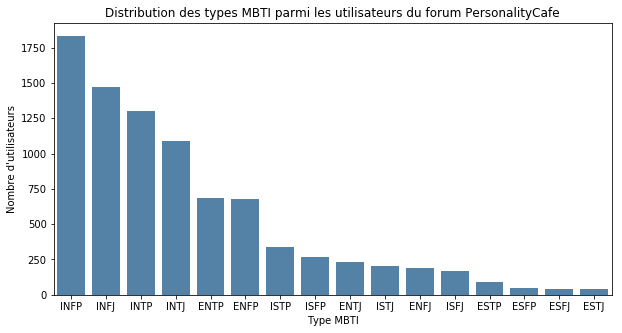

In [6]:
# Comptage des types MBTI
counts = data.type.value_counts()
mbti_types = counts.index
num_users = counts.values

# Tracé du graphique
plt.figure(figsize=(10,5))
sns.barplot(mbti_types, num_users, color="steelblue")
plt.xlabel("Type MBTI")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Distribution des types MBTI parmi les utilisateurs du forum PersonalityCafe");

Le graphe ci-dessus montre que **la distribution des types MBTI au sein du dataset n'est pas équilibrée**. En effet, il y a près de 2000 utilisateurs de type INFP, mais moins de 50 utilisateurs de type ESTJ.

Même s'il est possible que cette distribution reflète celle de la population mondiale, **les prédictions ne seront pas de qualité égale parmi les types MBTI**. On peut notamment s'attendre à ce qu'elles soient meilleures pour les INFP que les ESTJ.

Nous comprenons donc ici qu'il faudra **rééquilibrer les données** par des techniques que nous verrons plus loin.

### Exploration de features

Dans une démarche d'exploration, nous avons voulu inspecter plusieurs caractéristiques (*features*) construites à partir du dataset et les comparer pour chaque type MBTI. L'objectif est de découvrir des différences significatives.

#### Nombre moyen de mots par post

_Inspiré de [laowingkin/mbti-study-personality](https://www.kaggle.com/laowingkin/mbti-study-personality)._

In [7]:
from parser import parse_posts

def get_number_of_words(posts):
    parsed_posts = parse_posts(posts)
    num_words = sum(len(post.split()) for post in parsed_posts)
    return num_words / 50

# Ajout d'une nouvelle colonne au dataset :
# Nombre de mots pour chaque utilisateur moyenné sur l'ensemble de ses posts.
data['number_of_words'] = data['posts'].apply(get_number_of_words)

Tout d'abord, observons l'allure de la distribution du nombre moyen de mots par post, indépendamment du type MBTI :

25.476221325648417


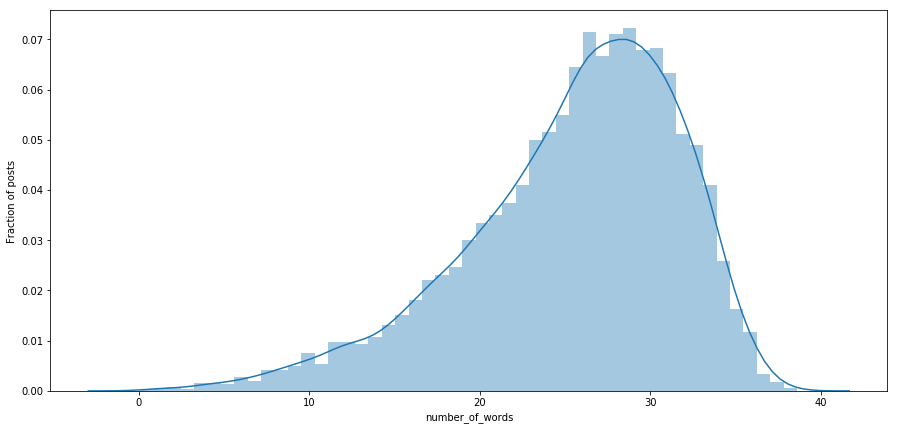

In [8]:
plt.figure(figsize=(15, 7))
ax = sns.distplot(data["number_of_words"], kde=True)
ax.set_ylabel("Fraction of posts");
print(data["number_of_words"].mean())

On constate donc qu'il y a environ 25 mots par post en moyenne, avec peu de posts long (30-40 mots) et plus de posts courts (10-25 mots).

Etudions maintenant le nombre moyen de mots selon le type MBTI.

- On présente les résultats sous la forme d'un *swarm plot* : les utilisateurs sont placés sur le graphe selon leur type MBTI (abscisse) et leur nombre moyen de mots par post (ordonnée).
- Le diagramme en barre superposé représente le nombre de mots moyen par type MBTI.

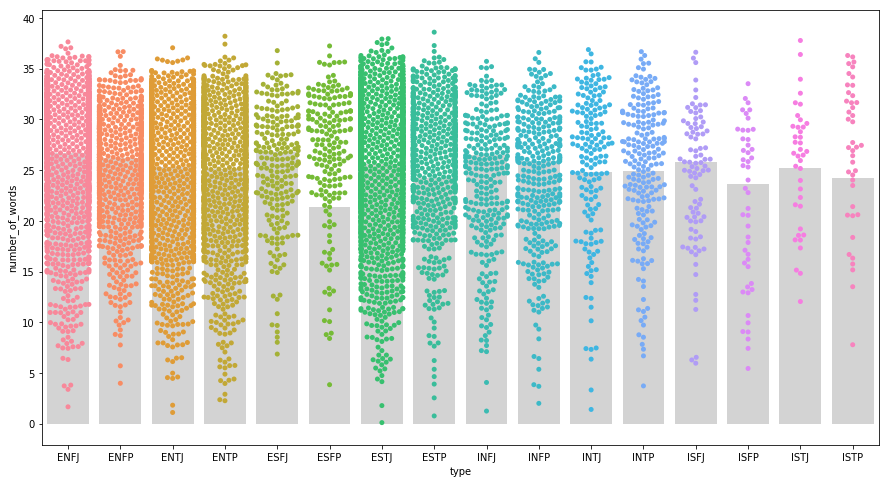

In [9]:
# Regroupement des nombres de mots par type MBTI.
num_words = data.groupby(data.type)["number_of_words"]

# Moyennage par type MBTI.
mean_words = num_words.mean()

# Tracé des figures.
plt.figure(figsize=(15, 8))
sns.swarmplot(x="type", y="number_of_words", data=data);
sns.barplot(mean_words.index, mean_words.values, color="lightgray");

Le diagramme ci-dessus montre à nouveau la répartition inégale des types MBTI dans le dataset. Les nombres de posts moyens sont par ailleurs équivalents. Les seuls écarts constatés (par exemple le type ESFP) ne sont pas significatifs parce qu'ils sont observés sur un type MBTI dont la population est bien plus faible.

En conclusion, il est difficile d'affirmer que le nombre moyen de mots par posts soit une caractéristiques qui aidera à prédire le type MBTI de l'auteur d'un texte. Nous n'incluerons donc pas cette grandeur pour entraîner les modèles.

#### Vocabulaire par type MBTI

Nous analysons ici le vocabulaire employé par les utilisateurs de chaque type MBTI afin de détecter de potentielles tendances.

Note : le calcul prend quelques temps.

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = nltk.WordNetLemmatizer()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stop_words = set(nltk.corpus.stopwords.words('english'))

def get_vocab(post):
    words = tokenizer.tokenize(post)
    words = (word.lower() for word in words)
    filtered_sentence = (w for w in words if not w in stop_words)
    lemms = [lemmatizer.lemmatize(word) for word in filtered_sentence]
    return nltk.FreqDist(lemms)

types = data.type.unique()

MOST_COMMON = 10

fmt = "{:<15} | {}"

header = fmt.format("Type", "{} most common words".format(MOST_COMMON))
print(header)
print("-" * len(header))

for t in types:
    # Récupération de tous les posts pour le type `t` sous la forme
    # d'une seule chaîne de caractères.
    posts = data.loc[data['type'] == t, :]['posts']
    content = ". ".join(p for p in posts)

    # Mots les plus communs pour le type `t`.
    vocab = get_vocab(content)
    most_common_words = vocab.most_common(MOST_COMMON)

    most_common = [word for word, frequency in most_common_words]
    print(fmt.format(t, ", ".join(most_common)))

[nltk_data] Downloading package punkt to /Users/Florimond/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Florimond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Florimond/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Type            | 10 most common words
--------------------------------------
INFJ            | like, think, people, know, one, infj, really, thing, time, would
ENTP            | like, think, people, one, entp, know, get, would, thing, really
INTP            | like, think, people, one, would, know, intp, thing, time, get
INTJ            | like, people, think, one, intj, would, know, time, thing, get
ENTJ            | like, think, people, one, entj, would, get, know, thing, type
ENFJ            | like, think, people, know, really, enfj, one, thing, get, would
INFP            | like, think, people, really, one, know, thing, time, infp, feel
ENFP            | like, think, people, enfp, know, one, really, thing, get, time
ISFP            | like, think, people, really, http, know, com, one, get, isfp
ISTP            | like, think, people, get, one, know, http, would, time, thing
ISFJ            | like, think, people, isfj, thing, really, time, one, know, would
ISTJ            | like, think,

Les utilisateurs partagent sensiblement le même vocabulaire, à savoir les mots *like*, *think* et *people* ainsi que leur propre type MBTI (par exemple les INFJ parlent des INFJ). On pourrait penser qu'il s'agit d'une caractéristique discriminante, sauf que le dataset est biaisé : les personnes du forum parlent d'eux-mêmes, par exemple pour illustrer leur propos.

En conclusion, le vocabulaire employé n'est pas une caractéristique intéressante à considérer pour les prédictions.

### Catégorisation par axe MBTI

#### Définition des catégories

Ajoutons des colonnes pour les indicateurs MBTI. On catégorie chaque axe de façon binaire sous la forme de 2 *variantes* :

| Axe | Code | Variante 0 | Variante 1 |
|-----|-------|------------|------------|
| Introversion - Extraversion | IE | I | E |
| Intuition - Sensation | NS | N | S |
| Feeling - Thinking | FT | F | T |
| Judgement - Perception | JP | J | P |

Cette catégorisation nous servira pour la suite pour tester des classificateurs sur seulement 2 classes plutôt que 16 (classificateurs binaires). [Par manque de temps nous n'avons pas pu tester les classifications binaires mais cela aurait pu être intéressant à étudier.]

#### Extension du dataset

In [11]:
from axisCategories import translate_personality

# Calcul des nouvelles colonnes.
axes_data = data.apply(lambda row: translate_personality(row), axis=1)

# Identification des axes MBTI.
mbti_axes = list(axes_data.columns)
print("Axes MBTI :", mbti_axes)

# Concaténation des colonnes au dataset.
data_types = data.join(axes_data)

# Aperçu du nouveau dataset.
data_types.head()

Axes MBTI : ['IE', 'NS', 'FT', 'JP']


,type,posts,number_of_words,IE,NS,FT,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,12.10,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,24.38,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,17.70,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",22.26,0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,20.32,1,0,1,0


#### Répartition des utilisateurs par variante

Visualisons maintenant la quantité d'utilisateurs pour chaque variante d'axe (par exemple, le nombre d'utilisateurs I ou E).

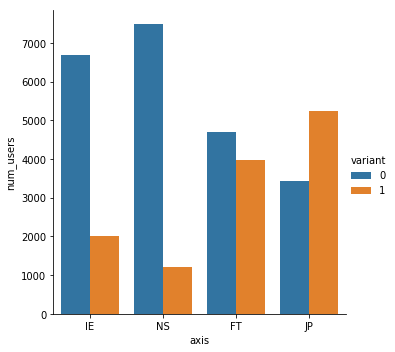

In [12]:
counts = []

for axis in mbti_axes:
    num_users = data_types[axis].value_counts()
    counts.append([axis, 0, num_users[0]])
    counts.append([axis, 1, num_users[1]])

counts_df = pd.DataFrame(counts, columns=("axis", "variant", "num_users"))

sns.catplot(x="axis", y="num_users", hue="variant", data=counts_df, kind="bar");

Le graphe ci-dessus montre par exemple qu'il y a environ 5 fois plus d'utilisateurs N (intuition) que S (Sensation), ce qui constitue une autre vision du déséquilibre entre les types MBTI.

#### Corrélation entre les axes

Calculons les coefficients de corrélation de Pearson entre les différents axes MBTI :

In [13]:
corr = data_types[mbti_axes].corr()
corr

,IE,NS,FT,JP
IE,1.000000,-0.045899,0.069573,0.161939
NS,-0.045899,1.000000,0.080954,0.014922
FT,0.069573,0.080954,1.000000,0.004673
JP,0.161939,0.014922,0.004673,1.000000


On peut représenter ces coefficients sous la forme d'une matrice de corrélation :

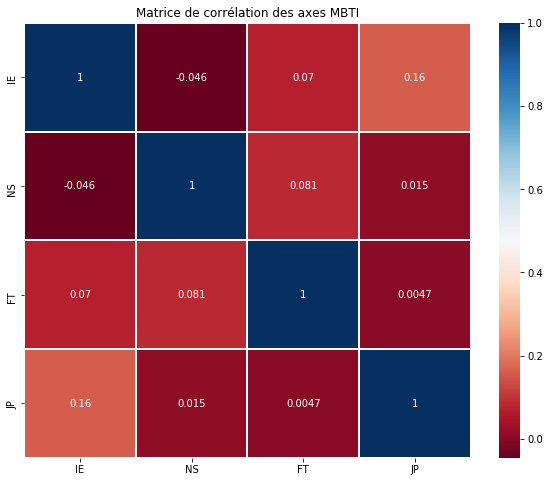

In [14]:
cmap = plt.cm.RdBu
plt.figure(figsize=(10, 8))
plt.title("Matrice de corrélation des axes MBTI")
sns.heatmap(corr, cmap=plt.cm.RdBu, annot=True, linewidths=1);

La matrice ci-dessus montre que les différents axes sont peu ou pas corrélés ($|corr| < 0.1$ sauf pour IE-JP).

## Apprentissage supervisé

Dans cette partie, on s'intéresse à la construction du classificateur de type MBTI. Nous évaluerons en particulier différents algorithmes de classification et méthodes d'équilibrage des données.

In [15]:
# Réinitialisation du dataset
data = get_dataset()

### Équilibre des données

Comme vu dans l'analyse graphique des données, le dataset est déséquilibré car les types MBTI ne sont pas tous représentés dans les mêmes proportions.

Si l'on ne corrige pas cela, on pourra subir le "paradoxe de l'accuracy" : l'accuracy serait le miroir de la répartition des classes.

Il y a plusieurs techniques pour gérer des données mal équilibrées. Nous allons en essayer certaines d'entre elles :

- L'**up-sampling** consiste à dupliquer de façon aléatoire des observations de la classe minoritaire afin de renforcer sa présence.
- Le **down-sampling** retire aléatoirement des observations de la classe majoritaire afin de réduire son influence lors de l'apprentissage.
- le **mid-sampling** sélectionne le type avec un nombre de posts moyen, et down-sample les classes ayant plus de posts et up-sample les classes ayant moins de posts. Cela fait un compromis entre les deux techniques, surtout sur ce dataset contenant des nombres de posts par classe très différentes (de 1700 à 40)

In [16]:
from resampling import upsample_minority, downsample_majority, midsample

print('Number of rows (original): {}'.format(data.shape[0]))
data_upsampled = upsample_minority(data)
print('Number of rows (upsample): {}'.format(data_upsampled.shape[0]))
data_downsampled = downsample_majority(data);
print('Number of rows (downsample): {}'.format(data_downsampled.shape[0]))
data_midsampled = midsample(data)
print('Number of rows (midsample): {}'.format(data_midsampled.shape[0]))


Number of rows (original): 8675
Number of rows (upsample): 29312
Number of rows (downsample): 624
Number of rows (midsample): 4336


### Preprocessing

Pour faire de l'apprentissage supervisé sur les données textuelles, il faut commencer par les processer. On supprime les caractères non-alphanumériques, on transforme le texte en minuscule, on retire les liens, etc.

Pour cela nous avons créé la fonction `format_text` dans `preprocessing.py`.

Note : le calcul peut prendre quelques minutes.

In [17]:
from preprocessing import format_text

print(data['posts'].head())
print('\nProcessed data :')
print(data['posts'].head().apply(format_text))

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
Name: posts, dtype: object

Processed data :
0     enfp and intj moments sportscenter not top te...
1     i m finding the lack of me in these posts ver...
2     good one of course to which i say i know that...
3     dear intp i enjoyed our conversation the othe...
4     you re fired that s another silly misconcepti...
Name: posts, dtype: object


### Vectorisation

Il s'agit dans cette partie d'extraire les features des posts en convertissant les textes en vecteurs de features numériques. On peut par exemple utiliser le modèle *Bag of Words* (BoW).

Le principe est le suivant : on découpe chaque texte en mots (en splittant sur les espaces) et on compte le nombre de fois où chaque mot apparaît dans chaque document. Enfin, on attribue à chaque mot un identifiant (nombre entier). Chaque mot unique de notre dictionnaire correspondra à une feature.

Le composant `CountVectorizer` de Scikit-learn nous permet de réaliser une telle opération et d'obtenir un vecteur à partir d'un texte.

### Méthode

Nous avons décidé de comparer plusieurs algorithmes de classification pour voir celui qui donnait de meilleurs résultats. Dans le fichier `classifier_comparison.py`, nous comparons les classificateurs suivants :

- Logistic Regression
- KNN
- Linear SVM
- Random Forest (100 estimateurs)
- Random Forest (50 estimateurs)
- Multinomial Naive Bayes

Le script teste d'abord sur un ensemble de test et de validation, puis fait de la validation croisée, en prenant en considération la mesure `f1_weighted`, qui calcule le f-score pour chaque classe puis moyenne le résultat. Il ne faut pas utiliser l'accuracy car le dataset est très biaisé : certaines classes sont bien plus majoritaires que d'autres.

Note : nous pourrions également calculer le Kappa Score de notre modèle. Cette mesure permet de comparer notre classificateur à un classificateur qui devinerait aléatoirement les classes suivant la fréquence de chaque classe. Le Kappa Score permet donc d'obtenir une accuracy normalisée par le déséquilibre des classes de notre dataset. Cependant cette mesure n'est pas disponible dans l'algorithme implémenté dans `cross_val_score()`.

### Résultats

Pour retrouver ces résultats, il suffit de faire tourner `classifier_comparison.py`. Attention : le calcul prend plusieurs longues minutes.

Pour les données de bases, les résultats sont :

| classifier | train_score | test_score | train_time | precision | recall  | f_score  |
| --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression   |  1.000000  |  0.603150  | 67.476075  | 0.410234  | 0.536156 | 0.464818 |
|          Linear SVM   |  0.992424  |  0.591625  |  9.015188  | 0.411437  | 0.569725 | 0.477813 |
|         Naive Bayes  |   0.688076 |   0.405686  |  0.201469 |  0.148439  | 0.208178 | 0.173305 |
|     Random Forest 100  |   1.000000 |   0.404149  | 34.869926 |  0.149514   | 0.219494 | 0.177868  |
|     Random Forest 50   |  1.000000   | 0.374184 |  16.287954  | 0.140585   | 0.225363 | 0.173154 |
|                  KNN  |   1.000000  |  0.248559  |  0.027554 |  0.108156 |  0.121756 | 0.114554 |  


Nous avons comparé les performances des différents datasets en validation croisée (en terme de `f1_weighted`) : dataset original, dataset down-sampled, dataset mid-sampled. Les résultats sont présentés ci-dessous. La valeur entre parenthèses représente l'écart-type de validation croisée.

|classifier | base | downsampled | midsampled |
|--- | --- | --- | --- | 
|Logistic Regression | 0.588 (0.021) | 0.398 (0.087) |   0.759 (0.018) |
|KNN | 0.226 (0.015) | 0.238 (0.049) | 0.481 (0.0280) |
|Linear SVM | 0.561 (0.027) | 0.376 (0.056) | 0.744 (0.023) |
|Random Forest 100 | 0.321 (0.019) | 0.391 (0.061) | 0.741 (0.012) |
|Random Forest 50 | 0.230 (0.012) | 0.355 (0.105)| 0.701 (0.026) |
|Naive Bayes | 0.318 (0.018) | 0.250 (0.052) |  0.645 (0.012) |


Remarques :

- Sur la dataset original, on voit que LogisticRegression est meilleur avec un score assez médiocre de 0.58.
- Logistic Regression est aussi meilleur pour le dataset downsampled, mais le score est de 0.39 — moins performant que sur le dataset original, donc.
- De plus, pour le dataset downsampled, l'écart-type est bien plus grand (x5 par rapport à l'original), ce qui montre que les résultats ne  vraiment mauvais.
- Nous n'avons pas réussi à avoir les résultats pour le dataset upsampled, car avec 1700 posts par type cela fait un dataset de 27 000 enregistrements : le temps de traitement est trop long.
- Nous avons donc fait du midsampling. Le temps de traitement est alors raisonnable. Les résultas sont bien meilleurs, avec un score de 0.75 pour Logistic Regression, qui reste le meilleur.
- Cependant il faut condidérer que midsampled augmente le nombre de données de certaines classes en dupliquant les posts. De fait, si un même post se trouve dans l'ensemble d'apprentissage et de test, il sera forcément bien prédit.

En conclusion, Logistic Regression couplé à un dataset midsampled est l'algorithme donnant les meilleures performances.

### Optimisation de Logistic Regression

Nous pouvons donc décidé de travailler sur Logistic Regression, en essayant de l'optimiser. Les paramètres de `LogisticRegression`, l'implémentation de Scikit-Learn, sur lesquels nous pouvons jouer sont `class_weight` qui définit des poids aux classes.

Avec le code ci-dessous nous avons lancé un test pour différentes valeurs. Attention : à cause du pré-traitement, le calcul peut être assez long.

Logistic Regression
trained Logistic Regression in 20.51 s
Logistic Regression Balanced
trained Logistic Regression Balanced in 20.34 s

==================================== Results ==================================== 


,classifier,train_score,test_score,train_time,precision,recall,f_score
0,Logistic Regression,1.0,0.761722,20.514314,0.763672,0.757151,0.760397
1,Logistic Regression Balanced,1.0,0.760184,20.343389,0.762128,0.755167,0.758631



f1_weighted
Logistic Regression: 0.749077 (0.017921)
Logistic Regression Balanced: 0.748566 (0.017855)


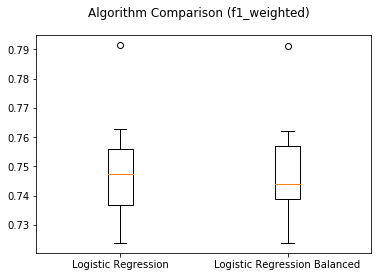

In [5]:
from classifier_comparison import compare_classifiers
from resampling import upsample_minority, downsample_majority, midsample

from sklearn.linear_model import LogisticRegression

# Categorized data frame
data = pd.read_csv("./data/mbti_1.csv", header=0)

# Choose sampling
# data = upsample_minority(data)
# data = downsample_majority(data)
data = midsample(data)

# Choose classifiers to compare
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression Balanced": LogisticRegression(class_weight='balanced'),
        
    }

compare_classifiers(dict_classifiers, data)

### Conclusions sur l'apprentissage

Finalement, nous voyons qu'en gardant les données originales, nous n'avons pas de très bons résultats, mais nous pouvons les améliorer en faisant du *resampling* (équilibrage de données). Les résultats s'améliorent notamment avec le *midsampling*.

Cependant les résultats obtenus ont leurs limites. Tout d'abord, nous utilisons le `CountVectorizer` de Scikit-learn, alors que nous avons vu lors de l'analyse que le nombre de mots et les vocabulaire ne sont pas représentatifs d'une classe. Ensuite, le *midsampling* a de meilleurs résultats en partie grâce à la duplication de données. Des techniques d'augmentation de données plus élaborées permettraient d'éviter la duplication qui peut introduire un biais lors de l'apprentissage.

Malgré cela, Logistic Regression nous permet un F1-score assez satisfaisant de 0.75.

Pour la suite, il serait intéressant d'étudier d'autres méthodes de représentation des posts : autre vectorisation du texte (TF-IDF, Word Embedding, etc.), mais également création de features. En effet, pour l'analyse les posts d'une personne sont considérés comme un seul gros texte. Il aurait donc été intéressant d'extraire des features des posts individuels et nous avions pensé aux features suivantes :

- longueur moyenne des posts (mots), 
- nombre moyen d'emojis, 
- nombre moyen de liens, 
- nombre moyen de questions,
- nombre moyen d'images,
- diversité du vocabulaire employé, 
- longueur moyenne d'une phrase.

On pourrait également se concentrer sur chaque axe MBTI en particulier (IE, NS, FT, JP) pour améliorer les performances de nos classificateurs. En effet, il est assez difficile de différencier les posts sur les 16 personnalités et il semblerait plus simple de ne classer que sur 2 labels opposés à la fois. Nous avions préparé les données pour ces classifications binaires mais n'avons pas eu le temps de vérifier cette hypothèse.

Nous avons également tracé les ROC curves pour un classificateur Naive Bayes dans le fichier `rocCurve.py`. Les ROC curves sont tracées sur des données binairisées, c'est-à-dire qu'on teste à chaque fois une classe par rapport à toutes les autres. En regardant l'aire sous la courbe (AUROC), on peut évaluer les performances du classificateur sur les différentes classes : plus l'aire est proche de 1, meilleur est le modèle. (Note : si l'AUROC est < 0.5, on doit simplement inverser les prédictions car Scikit-learn s'est trompé dans la classe positive - AUROC >= 0.5.)


## Conclusion

Sur la base de l'analyse présentée ici, nous souhaitons appliquer ce que nous avons appris concernant le dataset de commentaires de forum à un autre type de données textuelles : des tweets de personnalités, *cf* [twitter.ipynb](twitter.ipynb).